### Tutorial: Beat Frequencies

The reason why we have to optimize our observing strategy is aliasing. Aliasing is when two signals overlap because one is at an integer ratio or multiple frequency of the other. When this happens, it's difficult to tease out whether an observed signal is due to one or the other. Beat frequencies are the frequencies that interact with each other to cause aliasing. 

In [2]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import tinygp
from tinygp import kernels, GaussianProcess
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils



1.22.3
1.7.3


In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

path = '/Users/chrislam/Desktop/gaspery/'

In [21]:
### target parameters
p = 8.46 # orbital period, days
K = 5.80 # m/s
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019

### white/photon noise
sigma_wn_rv = 5 # [m/s]
sigma_qp_rv = 47 # m/s
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
Prot = 4.86

### choose start time as date of this writing
start = '2023-03-01T10:00:00'
start = Time(start, format='isot', scale='utc').jd

In [22]:
offs = []
n_obs = 30
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)

In [23]:
cadence = 1
strat = strategy.gappy(cadence = cadence)

In [24]:
# instantiate Star object in order to feed covariance matrix with white/correlated noise
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

# populate list of parameters to feed into cov_matrix_jax()
params = star.param_list()

# build covariance matrix, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

sigma = star.cov_matrix_general(strat, kernel)

1) orbital period = 4.86 days. Change nothing else.

In [27]:
p = 4.86 # instead of 8.46
K = 51.8
theta = [K, p, T0]
args = np.array(strat), sigma, jnp.array(theta, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]

fi_k = fim[0][0]
print(sigma_k)

29.05265611886857


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13513/3288354065.py:7: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


In [9]:
gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))


In [11]:
#strat = strat - T0 # re-index at T0 for ease of comparison
t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, theta))

In [ ]:
# reset figsize to default
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


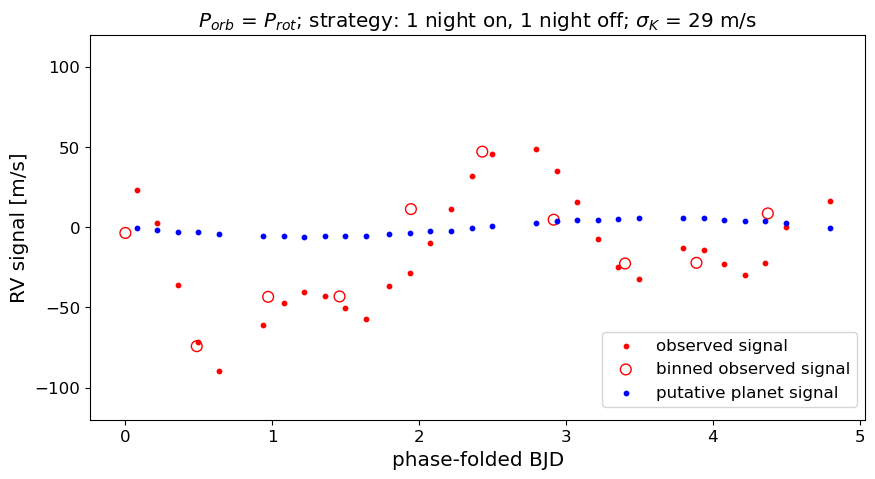

In [13]:
plt.rcParams["figure.figsize"] = (10,5)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

from scipy.stats import binned_statistic

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, theta)

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic((strat-T0) % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic((strat-T0) % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

plt.scatter((strat-T0) % p, sample + y_phase_folded, label='observed signal', c='red', s=10)
plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
            facecolors='none', edgecolors='r')
plt.scatter((strat-T0) % p, y_phase_folded, label='putative planet signal', c='blue', s=10)
#plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
#            facecolors='none', edgecolors='blue')

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.title(r'$P_{orb}$ = $P_{rot}$; strategy: 1 night on, 1 night off; $\sigma_K$ = 29 m/s')
plt.ylim([-120, 120])
plt.legend(bbox_to_anchor=(1.0, 0.25))
#plt.savefig(path + 'plots/au-mic/beat-freq1.pdf', format='pdf', bbox_inches='tight')
plt.show()

2) Beat frequency between orbital and rotation periods: one such frequency (printing "t1s_plus[10], periods[10]" from au-mic.ipynb) is cadence of 3.3 days and orbital period of 10.2 days.

In [14]:
p = 10.2
cadence = 3.3 #4.3

strat = strategy.gappy(cadence = cadence)

sigma = star.cov_matrix_general(strat, kernel)

theta = [K, p, T0]
args = np.array(strat), sigma, jnp.array(theta, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]

fi_k = fim[0][0]
print(sigma_k)

12.976476


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13513/808873331.py:12: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


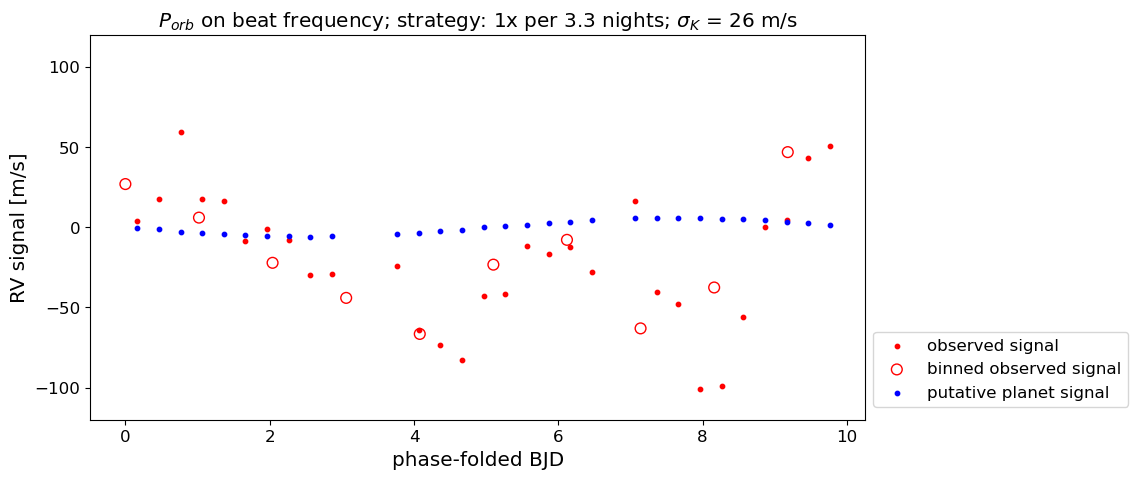

In [16]:
plt.rcParams["figure.figsize"] = (10,5)

gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))

t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, theta))

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, theta)

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic((strat-T0) % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic((strat-T0) % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

plt.scatter((strat-T0) % p, sample + y_phase_folded, label='observed signal', s=10, c='red')
plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
            facecolors='none', edgecolors='r')
plt.scatter((strat-T0) % p, y_phase_folded, label='putative planet signal', s=10, c='blue')
#plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
#            facecolors='none', edgecolors='blue')

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.ylim([-120, 120])
plt.title(r'$P_{orb}$ on beat frequency; strategy: 1x per 3.3 nights; $\sigma_K$ = 26 m/s')
plt.legend(bbox_to_anchor=(1.0, 0.25))
#plt.savefig(path + 'plots/au-mic/beat-freq2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Wait, at some point, wouldn't a non-integer cadence lead to wrapping around toward observing during the day?

3) Good strategy: cadence of exactly equal to Prot; orbital period of 6 days

In [29]:
p = 11
cadence = 4.86

strat = strategy.gappy(cadence = cadence)

sigma = star.cov_matrix_general(strat, kernel)

theta = [K, p, T0]
args = np.array(strat), sigma, jnp.array(theta, dtype=float)
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]

fi_k = fim[0][0]
print(sigma_k)

1.3188600954998242


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13513/694875897.py:12: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


In [ ]:
"""
gp1 = GaussianProcess(kernel, strat[:10])
sample1 = gp1.sample(jax.random.PRNGKey(4), shape=(1,))

gp2 = GaussianProcess(kernel, strat[10:15])
sample2 = gp2.sample(jax.random.PRNGKey(4), shape=(1,))

gp3 = GaussianProcess(kernel, strat[15:20])
sample3 = gp3.sample(jax.random.PRNGKey(4), shape=(1,))

gp4 = GaussianProcess(kernel, strat[20:25])
sample4 = gp4.sample(jax.random.PRNGKey(4), shape=(1,))

gp5 = GaussianProcess(kernel, strat[25:])
sample5 = gp5.sample(jax.random.PRNGKey(4), shape=(1,))

sample = np.concatenate((sample1, sample2, sample3, sample4, sample5), axis=1)[0]
print(sample)
"""

The GaussianProcess class of tinygp is failing for some parts of this strategy. Splitting it and sampling piecewise, and then putting it back together leads to overestimated errors. Turns out there's a troubleshooting section in the tinygp docs addressing this exact problem: https://tinygp.readthedocs.io/en/latest/troubleshooting.html

In [30]:
# needed to turn on double precision, per Troubleshooting section in docs
# otherwise, I just get nans
jax.config.update("jax_enable_x64", True)

gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))
print(sample)

[[63.20068312 65.26281466 66.64329106 67.2997348  67.21511971 66.39459318
  64.86985688 62.69562209 59.94860081 56.72497126 53.13651608 49.3069655
  45.36828282 41.45498769 37.70034189 34.23043094 31.1613713  28.59357054
  26.6101563  25.27155232 24.61658273 24.6571179  25.38183602 26.7538704
  28.71322739 31.17967748 34.05418264 37.22508991 40.57034349 43.96322845]]


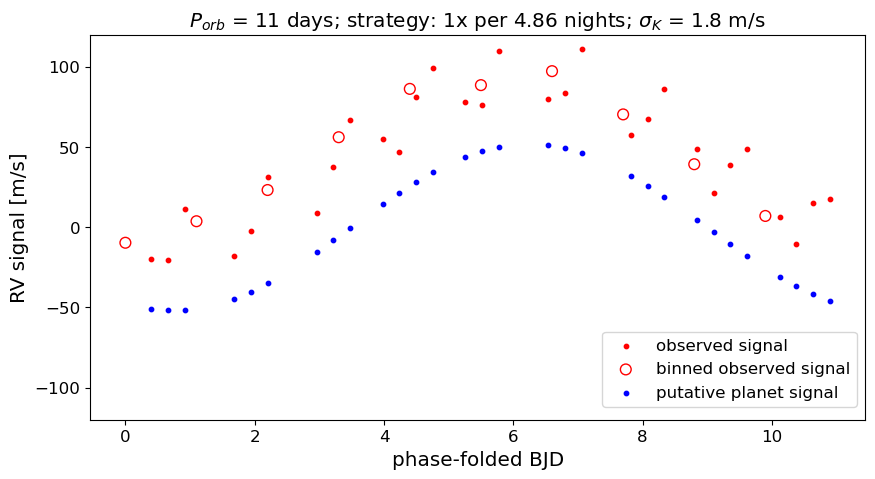

In [31]:
plt.rcParams["figure.figsize"] = (10,5)

strat = strat - T0

t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, theta))

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, theta)

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic(strat % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic(strat % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

plt.scatter(strat % p, sample + y_phase_folded, label='observed signal', s=10, c='red')
plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
            facecolors='none', edgecolors='r')
plt.scatter(strat % p, y_phase_folded, label='putative planet signal', s=10, c='blue')
#plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
#            facecolors='none', edgecolors='blue')

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.ylim([-120, 120])
plt.title(r'$P_{orb}$ = 11 days; strategy: 1x per 4.86 nights; $\sigma_K$ = 1.8 m/s')
plt.legend(bbox_to_anchor=(1.0, 0.25))
#plt.savefig(path + 'plots/au-mic/beat-freq3.pdf', format='pdf', bbox_inches='tight')
plt.show()

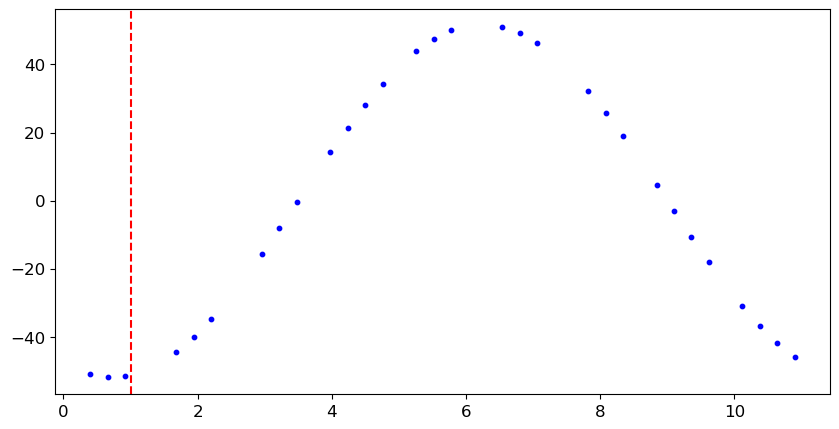

In [34]:
plt.scatter(strat % p, y_phase_folded, s=10, c='blue')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.show()